# Analyse the correlations with ENSO Index

In [8]:
# !pip install netcdf4

In [1]:
# !conda install -c conda-forge shap==0.30 --yes

In [2]:
# !conda update matplotlib

In [3]:
from pathlib import Path
import os
import warnings
from typing import Tuple, Optional, Union, Dict, List

%load_ext autoreload
%autoreload

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/jovyan/ml_drought


In [4]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

data_dir = Path('data/')

assert data_dir.exists()

In [5]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.utils import get_ds_mask

# Get the VCI data

In [54]:
X_train, y_train  = read_train_data(
    data_dir, experiment='one_month_forecast_BOKU_boku_VCI_our_vars'
)
X_test, y_test = read_test_data(
    data_dir, experiment='one_month_forecast_BOKU_boku_VCI_our_vars'
)

ds = xr.merge([y_train, y_test]).sortby('time').sortby('lat')
d_ = xr.merge([X_train, X_test]).sortby('time').sortby('lat')
ds = xr.merge([ds, d_])

In [55]:
ds

<xarray.Dataset>
Dimensions:     (lat: 45, lon: 35, time: 205)
Coordinates:
  * time        (time) datetime64[ns] 2001-12-31 2002-01-31 ... 2018-12-31
  * lat         (lat) float32 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.25 5.5 5.75 6.0
  * lon         (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
Data variables:
    boku_VCI    (time, lat, lon) float64 100.0 100.0 98.82 ... 11.94 78.34 40.51
    p84.162     (time, lat, lon) float64 1.45e-05 -5.456e-05 ... nan nan
    pev         (time, lat, lon) float64 -0.005993 -0.006077 ... nan nan
    sp          (time, lat, lon) float64 8.862e+04 8.927e+04 ... nan nan
    t2m         (time, lat, lon) float64 297.5 298.4 297.4 296.2 ... nan nan nan
    tp          (time, lat, lon) float64 0.003657 0.00285 0.004386 ... nan nan
    VCI         (time, lat, lon) float64 57.69 89.55 63.82 45.12 ... nan nan nan
    precip      (time, lat, lon) float64 102.0 107.6 122.3 111.1 ... nan nan nan
    E           (time, lat, lon) float64 85.9 60.61 60.61 57.43 ... nan nan nan
    Eb          (time, lat, lon) float64 3.518 1.266 1.266 2.995 ... nan nan nan
    SMroot      (time, lat, lon) float64 0.2638 0.2245 0.2245 ... nan nan nan
    SMsurf      (time, lat, lon) float64 0.2978 0.2648 0.2648 ... nan nan nan
    VCI3M       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    modis_ndvi  (time, lat, lon) float64 0.688 0.5456 0.7328 ... nan nan nan

# Get the ENSO data

In [62]:
def download_preprocess_enso(data_dir: Path) -> xr.Dataset:
    """Get Nino3.4 index and convert to xarray obj"""
    nino34_link = "https://www.esrl.noaa.gov/psd/data/correlation/nina34.data"
    nino34_link = "https://www.esrl.noaa.gov/psd/gcos_wgsp/Timeseries/Data/nino34.long.anom.data"
    name = 'nino34'

    # 1. PREPROCESS DATAFRAME
    # Download data and clean the table
    if 'anom' in nino34_link:
        df = pd.read_table(nino34_link, skiprows=0, nrows=149)
    else:
        df = pd.read_table(nino34_link, skiprows=0, nrows=73)
    # spaces to columns
    df = df.iloc[:, 0].str.split(expand=True)

    # wide to long format
    df = df.set_index(0).stack()
    df.name = name
    df = df.reset_index().rename(columns={0: 'year', 'level_1': 'month'})

    # create datetime index
    df['time'] = df.apply(lambda x: pd.to_datetime(f'{x.year}-{x.month}'), axis=1)
    df = df.set_index('time').drop(columns=['year', 'month'])

    # replace missing data
    df = df.astype({name: float}).replace(-99.99, np.nan)

    # resample to month end (same as other data)
    df = df.resample('M').first()

    # 2. CONVERT TO XARRAY
    vci = xr.open_dataset(
        data_dir / 'interim/boku_ndvi_1000_preprocessed/data_kenya.nc'
    )['boku_VCI']
    mask = vci.isnull()

    # for each MONTH TIMESTEP multiply by the nino value
    nino_xr = xr.ones_like(vci)
    nino_ts = df.loc[nino_xr.time.values]
    nino_xr = nino_xr * pd.DataFrame.to_xarray(nino_ts)
    nino_xr = nino_xr.where(~mask)

    if not (data_dir / 'analysis/sst').exists():
        (data_dir / 'analysis/sst').mkdir(parents=True, exist_ok=True)

    # save to netcdf
    nino_xr.to_netcdf(data_dir / f'analysis/sst/data_{name}.nc')
    return nino_xr


nino_xr = download_preprocess_enso(data_dir)
nino_xr

<xarray.Dataset>
Dimensions:  (lat: 45, lon: 35, time: 216)
Coordinates:
  * time     (time) datetime64[ns] 2001-12-31 2002-01-31 ... 2019-11-30
  * lat      (lat) float32 6.0 5.75 5.5 5.25 5.0 ... -4.0 -4.25 -4.5 -4.75 -5.0
  * lon      (lon) float32 33.75 34.0 34.25 34.5 34.75 ... 41.5 41.75 42.0 42.25
Data variables:
    nino34   (time, lat, lon) float64 -0.46 -0.46 -0.46 -0.46 ... nan nan nan

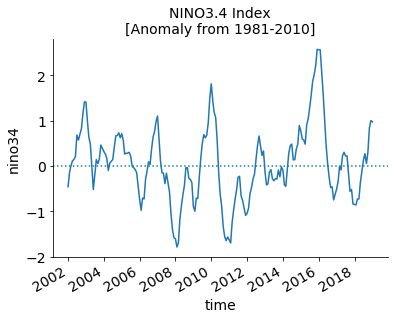

In [196]:
fig, ax = plt.subplots()
nino_xr.nino34.mean(dim=['lat', 'lon']).plot(ax=ax)
ax.set_title('NINO3.4 Index\n[Anomaly from 1981-2010]')

ax.axhline(0, ls=':')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] 
             + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

# Correlations with VCI

In [64]:
# !pip install git+https://github.com/hrishikeshac/mvstats.git

In [75]:
# https://github.com/hrishikeshac/mvstats/blob/master/mvstats/mvstats.py

def cov(x, y, time_axis = 0, lagx=0, lagy=0):
    """
    Computes covariance between x and y along time dimension, accounting for given lags (if any)
    Input: Two single- or multi-dimensional xrarray DataArray objects (x and y) which have 'time' as the first dimension.
        Default time axis is considered as 0, but can be changed using the 'time_axis' argument.
        Lag values (lagx for input data x, and lagy for input data y) can also be prescribed. Default lag values are zero.
    Output: An xarray DataArray object showing covariance between x and y along the 'time' dimension.
        If lag values are provided, the returned object will show lagged covariance.
    """
    #1. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards.
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time', how = 'all')

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time', how = 'all')

    #2. Ensure that the data are properly alinged to each other.
    x,y = xr.align(x,y)

    #3. Compute data length, mean and standard deviation along time dimension for further use:
    n     = x.time.shape[0]
    xmean = x.mean(dim='time')
    ymean = y.mean(dim='time')
    xstd  = x.std(dim='time')
    ystd  = y.std(dim='time')

    #4. Compute covariance along time dimension
    cov   =  np.sum((x - xmean)*(y - ymean), axis=time_axis)/(n)

    return cov

def cor(x, y, time_axis = 0,lagx=0, lagy=0):
    """
    Computes Pearson Correlation coefficient between x and y along time dimension, accounting for given lags (if any)
    Input: Two single- or multi-dimensional xrarray DataArray objects (x and y) which have 'time' as the first dimension
        Default time axis is considered as 0, but can be changed using the 'time_axis' argument.
        Lag values (lagx for input data x, and lagy for input data y) can also be prescribed. Default lag values are zero.
    Output: An xarray DataArray object showing Pearson Correlation coefficient between x and y along the 'time' dimension
        If lag values are provided, the returned object will show lagged correlation.
    """
    #1. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards.
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time', how = 'all')

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time', how = 'all')

    #2. Ensure that the data are properly alinged to each other.
    x,y = xr.align(x,y)

    #3. Compute data length, mean and standard deviation along time dimension for further use:
    n     = x.time.shape[0]
    xmean = x.mean(dim='time')
    ymean = y.mean(dim='time')
    xstd  = x.std(dim='time')
    ystd  = y.std(dim='time')

    #4. Compute covariance along time dimension
    cov   =  np.sum((x - xmean)*(y - ymean), axis=time_axis)/(n)

    #5. Compute correlation along time dimension
    cor   = cov/(xstd*ystd)

    return cor

def reg(x, y, time_axis = 0,lagx=0, lagy=0):
    """
    Computes simple linear regression slope and intercept for y with respect to x, accounting for given lags (if any)
    Input: Two single- or multi-dimensional xrarray DataArray objects (x and y) which have 'time' as the first dimension.
        Default time axis is considered as 0, but can be changed using the 'time_axis' argument.
        Lag values (lagx for input data x, and lagy for input data y) can also be prescribed. Default lag values are zero.
    Output: Two xarray DataArray objects showing estimated regression slope and intercept values for y with respect to x along the 'time' dimension.
        If lag values are provided, the returned object will show lagged regression.
    """
    #1. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards.
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time', how = 'all')

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time', how = 'all')

    #2. Ensure that the data are properly alinged to each other.
    x,y = xr.align(x,y)

    #3. Compute data length, mean and standard deviation along time dimension for further use:
    n     = x.time.shape[0]
    xmean = x.mean(dim='time')
    ymean = y.mean(dim='time')
    xstd  = x.std(dim='time')
    ystd  = y.std(dim='time')

    #4. Compute covariance along time dimension
    cov   =  np.sum((x - xmean)*(y - ymean), axis=time_axis)/(n)

    #5. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope

    return slope, intercept

def linregress_ND(x, y,time_axis = 0,lagx=0, lagy=0):
    """
    Multidimensional equivalent of scipy.stats.linregress()
    Input: Two single- or multi-dimensional xrarray DataArray objects (x and y) which have 'time' as the first dimension.
        Default time axis is considered as 0, but can be changed using the 'time_axis' argument.
        Lag values (lagx for input data x, and lagy for input data y) can also be prescribed. Default lag values are zero.
    Output: Xarray DataArray objects showing Covariance, correlation, regression slope and intercept, p-value, and standard error on regression (short: cov,cor,slope,intercept,pval,stderr)
    for y with respect to x along time dimension, accounting for given lags (if any)
    """
    #1. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards.
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time', how = 'all')

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time', how = 'all')

    #2. Ensure that the data are properly alinged to each other.
    x,y = xr.align(x,y)

    #3. Compute data length, mean and standard deviation along time axis for further use:
    n     = x.time.shape[0]
    xmean = x.mean(dim='time')
    ymean = y.mean(dim='time')
    xstd  = x.std(dim='time')
    ystd  = y.std(dim='time')

    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=time_axis)/(n)

    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)

    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope

    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats

    from scipy.stats import t
    pval   = t.sf(np.abs(tstats), n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

def detrend_ND_xr(y, rolling_mean_window = 0):
    """
    Use the reg() to detrend the data
    Input: An xarray DataArray object
        If seasonlity is not removed from the input array, a moving average filter can be applied by prescribing a value to rolling_mean_window
        (e.g. for monthly data, rolling_mean_window = 12 will remove seasonality). Default: rolling_mean_window = 0
    Output: Detrended input array. If a rolling_mean_window value is prescribed, the output data will have trimmed ends
    detrended data = y - (slope*x + intercept) + y.mean()
    """
    #1 Apply boxcar filter to remove seasonality
    y_deseason = y.rolling(time= rolling_mean_window, center=True).mean()#.dropna(dim='time', how = 'all')

    #2. Create index array 'x' for y
    x = xr.DataArray(np.arange(y.shape[0]), dims = ['time'], coords=[y.time])

    #3. Compute regression for deseaonsed y with respect to x
    slope, intercept = reg(x,y_deseason)

    #4 Compute trend for y
    y_trend = (slope*x + intercept)

    #5. Subtract the estimated trend from y
    det = y - y_trend + y.mean(dim='time')

    return det


In [152]:
def build_multi_lagged_ds(
    da_x: xr.DataArray, da_y: xr.DataArray, lags: List[int], v_str: Optional[str] = None
) -> xr.Dataset:
    """lag the y variable
        x    y 
        -------
        t   t-1
        t   t-2
        t   t-3
        
        Jan -> Dec
        Feb -> Jan
        Mar -> Feb
    """
    da_x = da_x.sortby(['time', 'lat', 'lon'])
    da_y = da_y.sortby(['time', 'lat', 'lon'])
    if v_str is None:
        v_str = f'{da_x.name}_{da_y.name}'
    all_ = []
    for lag in lags:
        print(f"Variable {da_y.name} Lag {lag}")
        var_name = f"cor_{da_y.name}_lag{lag}"
        all_.append(
            cor(da_x, da_y, lagy=lag).rename(var_name).values
        )

        cor_data = np.array(all_)  # lag, lat, lon
    
    # create xarray object
    ds = xr.Dataset(
        {
            v_str: (
                ["lag", "lat", "lon"],
                cor_data,
            )
        },
        coords={
            "lag": lags,
            "lon": da_y.lon,
            "lat": da_y.lat,
        },
    )

    return ds

In [153]:
cor_ds = build_multi_lagged_ds(
    da_x=ds.boku_VCI,
    da_y=nino_xr.nino34,
    lags=[0, 1, 2, 3],
)

Variable nino34 Lag 0
Variable nino34 Lag 1
Variable nino34 Lag 2
Variable nino34 Lag 3


(-0.4, 0.4)

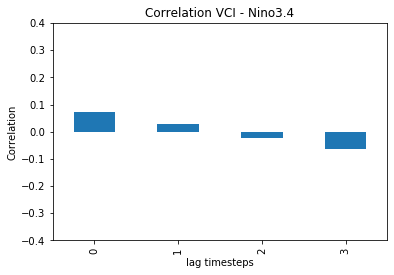

In [197]:
fig, ax = plt.subplots()
cor_ds.mean(dim=['lat', 'lon']).to_dataframe().plot.bar(ax=ax, legend=False)
ax.set_title('Correlation VCI - Nino3.4')
ax.set_ylabel('Correlation');
ax.set_xlabel('lag timesteps');
ax.set_ylim([-0.4, 0.4])
# plt.legend(fontsize=14)

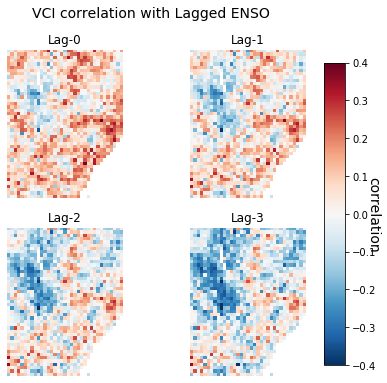

In [193]:
kwargs = {'vmin': -0.4, 'vmax':0.4, 'cmap':'RdBu_r'} #, 'add_colorbar': False}

fig, axs = plt.subplots(2, 2, figsize=(6, 6))
for ix, lag in enumerate(cor_ds.lag.values):
    ax_ix = np.unravel_index(ix, (2,2))
    ax = axs[ax_ix]
    vals = cor_ds.sel(lag=lag).boku_VCI_nino34.values[::-1, :]
    im = ax.imshow(vals, **kwargs)
    ax.set_title(f'Lag-{lag}')
    ax.axis('off')

cbar_ax = fig.add_axes([0.90, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel('correlation', rotation=270, size=14)
fig.suptitle('VCI correlation with Lagged ENSO', size=14);